In [158]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import joblib
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import unicodedata
import inflect
infl = inflect.engine()

In [69]:
pd.set_option("display.max_columns",None)

### Raw Data Import and Dataset Build

In [70]:
DATA = Path("dataset").resolve()
TEST_DF = Path("scratch_work_files").resolve()

In [71]:
# # Load only the first 10,000 reviews for testing
# reviews = []
# businesses = []
# with open(DATA / "yelp_academic_dataset_review.json", "r") as f1:
#     for i, line in enumerate(f1):
#         if i >= 250000:
#             break
#         reviews.append(json.loads(line))

# with open(DATA / "yelp_academic_dataset_business.json","r") as f2:
#     for i, line in enumerate(f2):
#         if i >= 250000:
#             break
#         businesses.append(json.loads(line))

# reviews_df = pd.merge(
#   pd.DataFrame(reviews),
#   pd.DataFrame(businesses),
#   how = "inner",
#   on = "business_id",
#   suffixes = ["_review","_restaurant"]
#   ).dropna()

# joblib.dump(reviews_df,TEST_DF / "review_testing_data.pkl")


In [72]:
reviews_df_complete = joblib.load(TEST_DF / "review_testing_data.pkl")

In [73]:
reviews_df_complete = pd.merge(
    reviews_df_complete,
    reviews_df_complete.groupby("business_id")["stars_review"].mean().rename("avg_stars"),
    how = "inner",
    on = "business_id"
)

In [74]:
cond1 = reviews_df_complete["categories"].str.lower().str.contains("restaurants")
cond2 = reviews_df_complete["categories"].str.lower().str.contains("hotels")
cond3 = reviews_df_complete["avg_stars"] < 4
reviews_df_complete = reviews_df_complete[
    (cond1) 
    & (~cond2)
#    & (cond3)
]

In [75]:
review_counts = reviews_df_complete.groupby("business_id")["review_id"].count().rename("total_reviews")
sample_id = review_counts[review_counts.between(100,200)].sample(3).index.tolist()

In [76]:
reviews_df = reviews_df_complete.copy()[reviews_df_complete["business_id"].isin(sample_id)]
reviews_df = reviews_df[["business_id","name","text"]].sort_values(by = "name").reset_index(drop = True)

In [77]:
reviews_df = pd.merge(reviews_df,review_counts,how = "inner",on = "business_id").drop('business_id',axis = 1)

### Function Builds

In [78]:
def CleanReviewText(text):
    """
    Removes & and nonstandard ascii characters to make the LLM's interpretation job easier
    """

    if not isinstance(text, str):
        return ""

    # Normalize Unicode (e.g., é → e)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")

    # Replace ampersands with "and" when used as a connector
    text = re.sub(r'\s*&\s*', ' and ', text)

    # Replace all forms of whitespace (tabs, newlines, multiple spaces) with a single space
    text = re.sub(r'\s+', ' ', text)

    # Trim leading/trailing whitespace
    return text.strip()


reviews_df["text"] = reviews_df["text"].apply(CleanReviewText)

In [79]:
def FormatClassList(values, max_items=None):
    """
    Transform the list of classes into different phrasings in natural English.
    Useful for dynamically passing possible classes to the prompt.
    """
    if max_items:
        values = values[:max_items]
    
    if not values:
        return ""
    elif len(values) == 1:
        return values[0]
    elif len(values) == 2:
        return f"{values[0]} and {values[1]}"
    else:
        return ", ".join(values[:-1]) + f", and {values[-1]}"

In [102]:
def BuildPrompt(business_name,classes,reprocess = False):
    """
    Build the prompt that will be passed to the LLM.
    Using a function allows the prompt to be printed and previewed.
    """

    prompt = f"""
You are a restaurant review classifier that is reviewing {business_name}.
Given a review of {business_name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {{"food": "[class]", "service": "[class]", "ambiance": "[class]"}}.
For [class], return one of {infl.number_to_words(len(valid_classes))} possible values: {FormatClassList(classes)}.
{FormatClassList(classes[:-1])} are classifications of the reviewer's feelings toward their experience.
Return "{FormatClassList(classes[-1:])}" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {{"food": "{classes[1]}", "service": "{classes[2]}", "ambiance": "{classes[3]}"}}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {{"food": "{classes[0]}", "service": "{classes[0]}", "ambiance": "{classes[0]}"}}.
No other output is desired.
    """
    if reprocess == True:
        prompt += f"""
Please focus on selecting a class from these values: {FormatClassList(classes)}. 
Other class choices, even if more descriptive, are not helpful in this instance.
If the reviewer has mixed opinions (a combination of positive, disappointed, and/or angry) about an aspect of their experience, bias toward the negative; 
that is, classify according to the more negative statements and choose "{valid_classes[0]}" only if the review is solely comprised of positive statements.
        """

    return prompt

In [81]:
def ClassifyReview(review_text, business_name, classes, model='mistral',reprocess = False):
    """
    Build the prompt and pass to the LLM for evaluation.
    """

    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
      
    data = {
        "model": model,
        "messages": [
            {
                "role": "system",
                "content": BuildPrompt(business_name,classes,reprocess) 
            },
            {
                "role": "user",
                "content": review_text
            }
        ],
        "stream": False
    }

    response = requests.post(url, json=data, headers=headers)
    return response.json()["message"]["content"]


In [82]:
def ParseReviewAnalyticsOutput(text):
    """
    Parses potentially messy JSON-like LLM output by:
    - Truncating after the first closing brace
    - Quoting unquoted keys
    - Quoting unquoted string values
    - Removing parenthetical commentary from values
    - Falling back to regex if JSON parsing fails
    Returns a dictionary with aspect classifications.
    """
    # Step 0: Truncate at first closing brace to avoid trailing commentary
    text = text.strip()
    closing_brace_index = text.find("}")
    if closing_brace_index != -1:
        text = text[:closing_brace_index + 1]

    # Step 0b: Remove parenthetical notes from values (e.g., "none (but blah)" -> "none")
    text = re.sub(r'"\s*([^"]*?)\s*\([^"]*\)"', r'"\1"', text)

    # Step 1: Fix unquoted keys
    text = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', text)

    # Step 2: Fix unquoted string values (assume words are categorical, not numbers or booleans)
    text = re.sub(r':\s*([a-zA-Z_]+)(\s*[,}])', r': "\1"\2', text)

    # Try JSON parsing
    try:
        parsed = json.loads(text)
        return {
            "food": parsed.get("food", "none").split()[0].lower(),
            "service": parsed.get("service", "none").split()[0].lower(),
            "ambiance": parsed.get("ambiance", "none").split()[0].lower()
        }
    except Exception:
        pass  # fallback to regex next

    # Fallback regex-based parsing
    result = {"food": "none", "service": "none", "ambiance": "none"}
    for aspect in ["food", "service", "ambiance"]:
        match = re.search(rf'{aspect}\s*[:=]\s*["\']?(\w+)', text, re.IGNORECASE)
        if match:
            result[aspect] = match.group(1).lower()

    return result


In [83]:
def GenerateReprocessData(df,classes):
    invalid_food = ~df["food"].isin(classes)
    invalid_service = ~df["service"].isin(classes)
    invalid_ambiance = ~df["ambiance"].isin(classes)

    to_reprocess = df[invalid_food | invalid_service | invalid_ambiance]
    df = df.drop(labels = to_reprocess.index)
    to_reprocess = to_reprocess.reset_index(drop=True)
    return df,to_reprocess

### Review Evaluation Config

In [103]:
valid_classes = ["positive","disappointed","angry","none"]
print(BuildPrompt(business_name="{restaurant name}",classes=valid_classes,reprocess=True))


You are a restaurant review classifier that is reviewing {restaurant name}.
Given a review of {restaurant name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {"food": "[class]", "service": "[class]", "ambiance": "[class]"}.
For [class], return one of four possible values: positive, disappointed, angry, and none.
positive, disappointed, and angry are classifications of the reviewer's feelings toward their experience.
Return "none" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {"food": "disappointed", "service": "angry", "ambiance": "none"}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {"

### Process Analytics

In [85]:
%%time

result_list = []
for review in reviews_df.itertuples():
    result = ClassifyReview(review.text,business_name=review.name,classes=valid_classes,reprocess = False)
    result_list.append(result)

CPU times: user 1.34 s, sys: 294 ms, total: 1.63 s
Wall time: 14min 34s


In [86]:
result_df = pd.concat([reviews_df,(pd.DataFrame(pd.Series(result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

In [87]:
# result_df["check_col"] = (
# result_df["food"].str.strip().str.lower()
# + result_df["service"].str.strip().str.lower()
# + result_df["ambiance"].str.strip().str.lower()
# )

# result_df[result_df["check_col"] == "nonenonenone"]

### Reprocess Analytics for Noncompliant Rows

In [33]:
# from random import randint
# counter = 0
# while counter < 5:
#     result_df.loc[randint(0,99),["food"]] = "N/A"
#     result_df.loc[randint(0,99),["ambiance"]] = "N/A"
#     result_df.loc[randint(0,99),["service"]] = "N/A"
#     counter +=1


In [ ]:
# "neutral" is a common hallucination that the LLM has; this is best replaced with "none" to save reprocessing compute
result_df = result_df.replace(to_replace="neutral",value="none")

In [94]:
result_df,to_reprocess = GenerateReprocessData(result_df,valid_classes)

In [108]:
to_reprocess

,name,text,total_reviews,food,service,ambiance
0,LaScala's,Went here for Valentine's Day. The ambiance is...,172,positive,disappointed_turned_positive,positive
1,LaScala's,Holy Pasta Batman! Went here with a date and m...,172,positive,disappointed,mixed
2,LaScala's,If the name of my restaurant was my last name ...,172,positive,none,mixed


In [109]:
%%time

repr_result_list = []
for review_repr in to_reprocess.itertuples():
    repr_result = ClassifyReview(review_repr.text,business_name=review_repr.name,classes=valid_classes,reprocess = True)
    repr_result_list.append(repr_result)

CPU times: user 11.5 ms, sys: 4.46 ms, total: 15.9 ms
Wall time: 9.51 s


In [110]:
reprocessed = pd.concat([to_reprocess[["name","text","total_reviews"]],(pd.DataFrame(pd.Series(repr_result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

### Final Reprocess Cycle: Replace Noncompliant Rows With 'none'

In [111]:
reprocessed

,name,text,total_reviews,food,service,ambiance
0,LaScala's,Went here for Valentine's Day. The ambiance is...,172,positive,disappointed_turned_positive,positive
1,LaScala's,Holy Pasta Batman! Went here with a date and m...,172,positive,disappointed,none
2,LaScala's,If the name of my restaurant was my last name ...,172,positive,positive,disappointed


In [112]:
if reprocessed.shape[0] > 0:
    reprocessed.loc[~reprocessed["food"].isin(valid_classes),["food"]] = "none"
    reprocessed.loc[~reprocessed["service"].isin(valid_classes),["service"]] = "none"
    reprocessed.loc[~reprocessed["ambiance"].isin(valid_classes),["ambiance"]] = "none"


In [113]:
result_df = pd.concat([result_df,reprocessed],axis = 0).reset_index(drop = True)

### Load Result DF Here

In [126]:
joblib.dump(result_df,"scratch_work_files/results_sample.pkl")
# result_df = joblib.load("scratch_work_files/results_sample.pkl")

['scratch_work_files/results_sample.pkl']

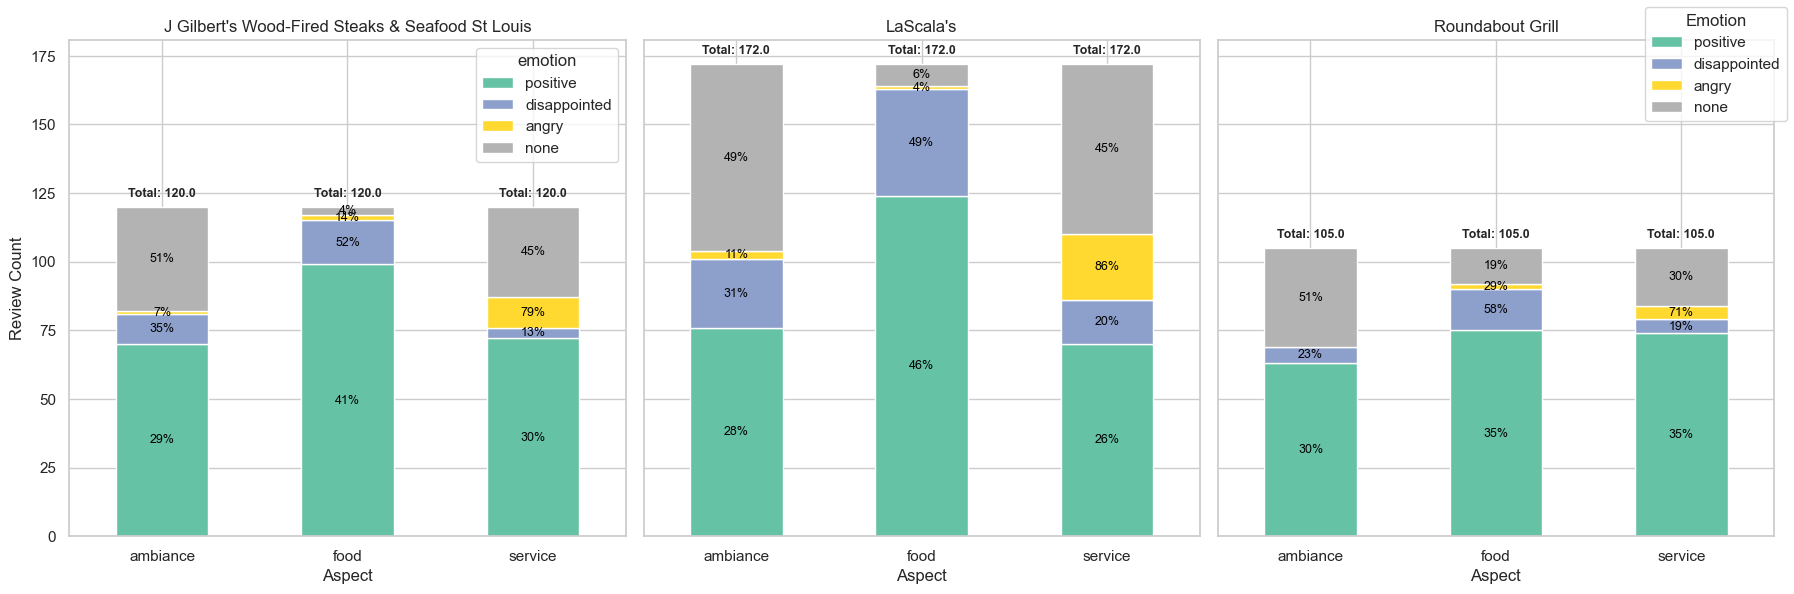

In [196]:
# 1. Melt into long format
melted = result_df.melt(
    id_vars="name",
    value_vars=["food", "service", "ambiance"],
    var_name="aspect",
    value_name="emotion"
)

# 2. Count occurrences
counts = (
    melted.groupby(["name", "aspect", "emotion"])
    .size()
    .reset_index(name="count")
)

# 3. Pivot for stacked bars
pivoted = counts.pivot_table(
    index=["name", "aspect"],
    columns="emotion",
    values="count",
    fill_value=0
)

# Ensure consistent emotion order
emotion_order = ["positive", "disappointed", "angry", "none"]
pivoted = pivoted.reindex(columns=emotion_order, fill_value=0)

# 4. Add row totals for percentage & total labels
pivoted["total"] = pivoted.sum(axis=1)

# 5. Create subplots
restaurants = pivoted.index.get_level_values(0).unique()
n_restaurants = len(restaurants)

fig, axes = plt.subplots(1, n_restaurants, figsize=(6 * n_restaurants, 6), sharey=True)

if n_restaurants == 1:
    axes = [axes]

for ax, restaurant in zip(axes, restaurants):
    group = pivoted.loc[restaurant]
    group_no_total = group.drop(columns="total")

    # Plot stacked bars
    group_no_total.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="Set2",
        legend=(ax == axes[0])
    )
    ax.set_title(restaurant)
    ax.set_ylabel("Review Count")
    ax.set_xlabel("Aspect")
    ax.tick_params(axis="x", rotation=0)

    # Add percentage labels inside bars + totals above bars
    for container in ax.containers:  # each bar stack
        labels = []
        for rect in container:
            height = rect.get_height()
            if height > 0:
                # Get total for this bar
                bar_total = group.loc[rect.get_x() + rect.get_width()/2].total if False else None
                # Percent of that aspect
                aspect = rect.get_x() + rect.get_width()/2  # placeholder
            labels.append("")

        # annotate percentages
        for rect in container:
            height = rect.get_height()
            if height > 0:
                aspect = rect.get_x() + rect.get_width()/2  # not used yet
                total_height = sum([r.get_height() for r in container])
                percentage = 100 * height / total_height
                ax.annotate(f"{percentage:.0f}%",
                            xy=(rect.get_x() + rect.get_width() / 2,
                                rect.get_y() + height / 2),
                            ha="center", va="center", fontsize=9, color="black")

    # Add total count labels above bars
    for idx, (aspect, row) in enumerate(group.iterrows()):
        total = row["total"]
        ax.annotate(f"Total: {total}",
                    xy=(idx, total),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9, fontweight="bold")

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Emotion", loc="upper right")

plt.tight_layout()
plt.show()
